In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging


In [3]:
logging.basicConfig(level = logging.INFO, 
                            format='%(levelname)s : %(asctime)s : %(filename)s Line : %(lineno)d - %(message)s')

In [4]:
data = pd.read_csv('./data/beer_reviews.csv.bz2')

In [5]:
data.head(2)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213


In [6]:
data.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

#### Drop data with 'NaN' in review_profilename

In [7]:
data = data[~data['review_profilename'].isna()]

### Data 
-----
- user : review_profilename
- item : beer_name
- ratings : review_overall

In [8]:
sel_col = ['review_profilename', 'beer_name', 'review_overall']

In [9]:
data_sel = data[sel_col]

In [10]:
data_sel.shape

(1586266, 3)

In [11]:
data_sel['review_overall'].describe()

count    1.586266e+06
mean     3.815628e+00
std      7.205948e-01
min      0.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: review_overall, dtype: float64

In [12]:
review_counts = data_sel['review_profilename'].value_counts()


In [13]:
review_counts = pd.DataFrame({'reviewer' : review_counts.index, 
                              'count' : review_counts.values})

In [14]:
review_counts[-5:]

,reviewer,count
33382,alexmeier175,1
33383,travisjohn,1
33384,dts6gc,1
33385,stylzdlux,1
33386,Schells,1


In [16]:
beer_counts = data_sel['beer_name'].value_counts()


In [17]:
beer_counts = pd.DataFrame({'beer' : beer_counts.index, 
                            'count' : beer_counts.values})

In [18]:
beer_counts[-5:]

,beer,count
56851,Kitzmann Urbock,1
56852,Bamberg München,1
56853,Big Dog's Dog's Bollocks,1
56854,Organic Bock,1
56855,Prima,1


### Data blance 
---------------
- 31% of reviewer reviewed only 1 time 
- a third of the beer_name got only 1 review

In [19]:
(review_counts==1).mean()

INFO : 2021-01-11 09:25:13,655 : utils.py Line : 129 - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO : 2021-01-11 09:25:13,656 : utils.py Line : 141 - NumExpr defaulting to 8 threads.


reviewer    0.000000
count       0.312786
dtype: float64

In [20]:
(beer_counts==1).mean()

beer     0.000000
count    0.332612
dtype: float64

In [21]:
data_sel.head(2)

,review_profilename,beer_name,review_overall
0,stcules,Sausa Weizen,1.5
1,stcules,Red Moon,3.0


### Categorical encoding 
--------------
- encoding the (1) review_profilename, (2) beer_name into numerical number 

In [22]:
reviewertoidx_dic  = dict(zip(review_counts['reviewer'], review_counts.index.values))
reviewer_dic  = dict(zip(review_counts.index.values, review_counts['reviewer']))

In [23]:
beertoidx_dic  = dict(zip(beer_counts['beer'], beer_counts.index.values))
beer_dic  = dict(zip(beer_counts.index.values, beer_counts['beer']))

In [24]:
data_sel['review_profilename'] = data_sel['review_profilename'].map(reviewertoidx_dic)
data_sel['beer_name'] = data_sel['beer_name'].map(beertoidx_dic)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
data_sel.head(2)

,review_profilename,beer_name,review_overall
0,73,49815,1.5
1,73,50198,3.0


In [26]:
data_sel.isna().sum()

review_profilename    0
beer_name             0
review_overall        0
dtype: int64

In [27]:
n_users = len(reviewer_dic) 
n_items = len(beer_dic) 

## MF embedding 
-------------

In [27]:
import keras
from keras.layers import *
from keras.regularizers import *
from keras.models import *
import keras.backend as K
from src.model import EmbedModel

In [30]:
base_class = EmbedModel(n_users, n_items)

In [31]:
model = base_class.build()

In [32]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embed (Embedding)          (None, 1, 20)        667740      user_input[0][0]                 
__________________________________________________________________________________________________
item_embed (Embedding)          (None, 1, 20)        1137120     item_input[0][0]                 
_______________________________________________________________________________________

### Embedding the categorical Input data to embedding space(embed_size)

In [34]:
model.compile('Adam',loss='mse')

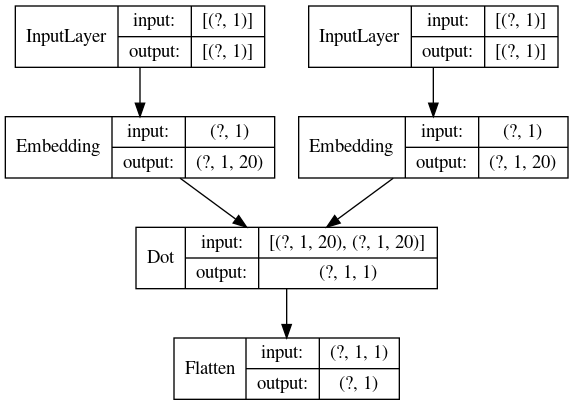

In [35]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [36]:
data_sel.head(2)

,review_profilename,beer_name,review_overall
0,72,51747,1.5
1,72,52529,3.0


In [37]:
users_data = data_sel[['review_profilename']].values
items_data = data_sel[['beer_name']].values
y_data = data_sel[['review_overall']].values

In [38]:
N_EPOCHS = 20
BATCH_SIZE = 256

In [39]:
hs = model.fit(x=[users_data, items_data], 
               y=y_data, 
               batch_size=BATCH_SIZE,
               epochs=N_EPOCHS, 
               validation_split=0.2, 
               verbose=2)


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4958/4958 - 17s - loss: 6.2819 - val_loss: 14.6847
Epoch 2/20
4958/4958 - 17s - loss: 2.3115 - val_loss: 14.7561
Epoch 3/20
4958/4958 - 17s - loss: 2.0800 - val_loss: 14.7883
Epoch 4/20
4958/4958 - 17s - loss: 2.0203 - val_loss: 14.7950
Epoch 5/20
4958/4958 - 17s - loss: 1.9789 - val_loss: 14.7866
Epoch 6/20
4958/4958 - 17s - loss: 1.9442 - val_loss: 14.7853
Epoch 7/20
4958/4958 - 17s - loss: 1.9155 - val_loss: 14.7729
Epoch 8/20
4958/4958 - 17s - loss: 1.8935 - val_loss: 14.7727
Epoch 9/20
4958/4958 - 17s - loss: 1.8756 - val_loss: 14.7706
Epoch 10/20
4958/4958 - 17s - loss: 1.8628 - val_loss: 14.7670
Epoch 11/20
4958/4958 - 17s - loss: 1.8529 - val_loss: 14.7776
Epoch 12/20
4958/4958 - 17s - loss: 1.8457 - val_loss: 14.7799
Epoch 13/20
4958/4958 - 17s - loss: 1.8393 - val_loss: 14.7796
Epoch 14/20
4958/4958 - 17s - loss: 1.8346 - val_loss: 14.7902
Epoch 15/20
4958/4958 - 17s - loss: 1.8312 - val_loss: 14.7966
Epoch 16/20
4958/4958 - 17s - loss: 1.8284 - val_loss: 14.7927
Epoch 17/20


In [42]:
pred = model.predict([users_data, items_data], batch_size=BATCH_SIZE)

In [43]:
pred.max()

6.7121973

#### Recommendation for users 

In [44]:
check_user_id = 41
reviewer_dic[check_user_id]

'Zorro'

In [59]:
rec = base_class.get_recommendation(check_user_id, beer_dic, 20)

In [60]:
rec

{'Flywheel Bright Lager': 4.8800135,
 'Luscious': 4.9109354,
 'Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)': 5.1275706,
 'Kaggen! Stormaktsporter': 4.896656,
 'Double Sunshine IPA': 5.002725,
 'Saison Dupont': 4.8780117,
 'Sierra Nevada Pale Ale': 4.9027367,
 'Stone IPA (India Pale Ale)': 4.8650393,
 'Pliny The Elder': 5.1965,
 '32/50': 4.955534,
 'Westmalle Trappist Tripel': 4.8700485,
 "Armand'4 Oude Geuze Lente (Spring)": 5.0963373,
 'Dirty Horse': 4.944423,
 'Weihenstephaner Hefeweissbier': 5.2589226,
 'Duvel': 5.0470743,
 'Chimay Grande Réserve (Blue)': 5.108633,
 "Samuel Smith's Oatmeal Stout": 4.928898,
 'Ayinger Celebrator Doppelbock': 4.8765574,
 'Adam From The Wood': 4.8577843,
 'Deviation - Bottleworks 9th Anniversary': 4.84328}

In [55]:
sel_idx = data['review_profilename']==reviewer_dic[check_user_id]
rec_data = data[sel_idx].sort_values(by = ['review_overall'], ascending=False)

#### Find the real reviewed beer with highest score 5.0 

In [67]:
set(rec_data[rec_data['review_overall']>4.5]['beer_name']).intersection(set(rec.keys()))

{'Ayinger Celebrator Doppelbock',
 'Pliny The Elder',
 'Saison Dupont',
 "Samuel Smith's Oatmeal Stout",
 'Weihenstephaner Hefeweissbier'}